# 使用Transformer+MLP，对给定的小时级u,v，给出小时级power_total

## 定义数据集及其处理方式。定义对于power的数据集

In [1]:
import pandas as pd
import numpy as np

path = r'E:\PKU_ThirdGrade_Autumn\机器学习基础'
u_wind = []
v_wind = []
capacity = []
power = []
sample_number = [0,1000,2000,3000,4000,5000]
for j in range(1,6):
    for i in range(sample_number[j-1],sample_number[j]):
        if i == 4014:
            continue
        u_file = path + rf'\Results_{j}\data_{i}\u.csv'
        v_file = path + rf'\Results_{j}\data_{i}\v.csv'
        capacity_file = path + rf'\Results_{j}\data_{i}\capacity.csv'
        power_file = path + rf'\Results_{j}\data_{i}\power.csv'
        df = pd.read_csv(u_file,header = None)
        u_wind.append(df.iloc[:,0].values)
        df = pd.read_csv(v_file,header = None)
        v_wind.append(df.iloc[:,0].values)
        df = pd.read_csv(power_file)
        power.append(df.iloc[2:,10].values)
        df = pd.read_csv(capacity_file)
        capacity.append(df.iloc[1:,10].values)
    
u_wind = np.array(u_wind)
v_wind = np.array(v_wind)
capacity = np.array(capacity)
power = np.array(power)
print(u_wind.shape)
print(v_wind.shape)
print(capacity.shape)
print(power.shape)

(4999, 8760)
(4999, 8760)
(4999, 12)
(4999, 8760)


In [2]:
u_wind = np.transpose(u_wind)
v_wind = np.transpose(v_wind)
capacity = np.transpose(capacity)
power = np.transpose(power)
print(u_wind.shape)
print(v_wind.shape)
print(capacity.shape)
print(power.shape)
input_size = u_wind.shape[0] 
output_capacity_size = capacity.shape[0]
output_power_size = power.shape[0]

(8760, 4999)
(8760, 4999)
(12, 4999)
(8760, 4999)


In [3]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch
import matplotlib.pyplot as plt

sample_number = 4999
def data_initialization(u_wind,v_wind,capacity,power):
    input_merged, target1, target2 = [], [], []
    for i in range(sample_number):
        u_wind_sample = list(u_wind[:,i])
        v_wind_sample = list(v_wind[:,i])
        capacity_sample = list(capacity[:,i])
        power_sample = list(power[:,i])
        u_wind_sample = np.array(u_wind_sample)
        v_wind_sample = np.array(v_wind_sample)
        input_sample = np.column_stack((u_wind_sample, v_wind_sample))
        input_merged.append(input_sample)
        target1.append(capacity_sample)
        target2.append(power_sample)
        
    return np.array(input_merged), np.array(target1), np.array(target2)

class dataset_to_Dataset(Dataset):
    def __init__(self,data_input_merged,data_target):
        self.len = data_input_merged.shape[0]
        print(data_input_merged.shape)
        print(data_target.shape)
        self.input_merged = torch.from_numpy(data_input_merged)
        self.target1 = torch.from_numpy(data_target)
        min_val = self.target1.min(dim=1, keepdim=True)[0]  # 每行的最小值
        max_val = self.target1.max(dim=1, keepdim=True)[0]  # 每行的最大值
        self.target1_normalized = (self.target1 - min_val) / (max_val - min_val)
        print(self.target1_normalized.shape)
        
    def __getitem__(self,index):
        return self.input_merged[index,:,:],self.target1_normalized[index,:]
    
    def __len__(self):
        return self.len
    
def dataset_split_6sets(data_input_merged, data_target1,data_target2, ratio=0.9):
    split_index = int(ratio*sample_number)
    train_input_merged = data_input_merged[:split_index,:]
    train_target1 = data_target1[:split_index,:]
    train_target2 = data_target2[:split_index,:]
    test_input_merged = data_input_merged[split_index:,:]
    test_target1 = data_target1[split_index:,:]
    test_target2 = data_target2[split_index:,:]
    return train_input_merged, train_target1,train_target2,test_input_merged, test_target1,test_target2

## 搭建Transformer+MLP

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, seq_len, num_heads=8, num_layers=6, ff_dim=32, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim,ff_dim)
        self.positional_encoding = nn.Parameter(torch.zeros(1,seq_len,ff_dim))
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model = ff_dim,
            nhead = num_heads,
            dim_feedforward = ff_dim,
            dropout = dropout
        )
        self.encoder = nn.TransformerEncoder(self.encoder_layer,num_layers=num_layers)
        self.fc_out = nn.Linear(ff_dim, output_dim)
        
    def forward(self, x):
        x = self.embedding(x)
        x = x + self.positional_encoding
        x = self.encoder(x)
        output = self.fc_out(x)
        output = output.squeeze(-1)
        return output
    
input_dim = 2
output_dim = 1
seq_len = 8760

## 开始训练

In [5]:
import time
import torch.nn as nn
import torch.optim as optim
import torch
# Example inputs
BATCH_SIZE = 64
LEARN_RATE = 1e-3

dataset_input_merged, dataset_target1,dataset_target2 = data_initialization(u_wind,v_wind, capacity, power)
print(dataset_input_merged.shape)
print(dataset_target1.shape)
print(dataset_target2.shape)
dataset_input_merged = dataset_input_merged.astype(np.float32)
dataset_target1 = dataset_target1.astype(np.float32)
dataset_target2 = dataset_target2.astype(np.float32)

train_input_merged, train_target1,train_target2,test_input_merged, test_target1,test_target2 = dataset_split_6sets(dataset_input_merged, dataset_target1,dataset_target2)
train_set = dataset_to_Dataset(train_input_merged,train_target2)

train_set_iter = DataLoader(dataset=train_set,# 将数据封装进Dataloader类
                            batch_size=BATCH_SIZE,
                            shuffle=True,  # 打乱batch与batch之间的顺序
                            drop_last=True)# drop_last = True表示最后不够一个batch就舍弃那些多余的数据


(4999, 8760, 2)
(4999, 12)
(4999, 8760)
(4499, 8760, 2)
(4499, 8760)
torch.Size([4499, 8760])


In [6]:
EPOCH = 150

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = TransformerModel(input_dim, output_dim,seq_len).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARN_RATE)

BATCH_SIZE =64
loss_plot = []
input_size = 8760
power_size = 8760
torch.cuda.empty_cache()
start = time.perf_counter()

for epoch in range(EPOCH):
    loss_print = []
    for batch_idx, (x, y1) in enumerate(train_set_iter):
        x = x.reshape([BATCH_SIZE, input_size, 2])
        x = x.to(device)
        y1 = y1.reshape((BATCH_SIZE,power_size))
        y1 = y1.to(device)
        y1_pred = model(x)
        loss = criterion(y1, y1_pred)
        loss_print.append(loss.item())
        # 三大步
        # 网络的梯度值更为0
        model.zero_grad()
        # loss反向传播
        loss.backward()
        # 优化器更新
        optimizer.step()
    print(f'{epoch} of loss: LSTM+Multitask+MLP:loss:',sum(loss_print)/len(loss_print))
    loss_plot.append(sum(loss_print)/len(loss_print))
        
end = time.perf_counter()
print('训练时间为：{:.2f}s'.format(end-start))

cuda


E:\Anaconda\AnacondaInstall\envs\pytorch\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
E:\Anaconda\AnacondaInstall\envs\pytorch\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


0 of loss: LSTM+Multitask+MLP:loss: 0.0597742661567671
1 of loss: LSTM+Multitask+MLP:loss: 0.029800841185663427
2 of loss: LSTM+Multitask+MLP:loss: 0.027786145226231643
3 of loss: LSTM+Multitask+MLP:loss: 0.025391319101410254
4 of loss: LSTM+Multitask+MLP:loss: 0.02188318930566311
5 of loss: LSTM+Multitask+MLP:loss: 0.012544042164725917
6 of loss: LSTM+Multitask+MLP:loss: 0.005062783363142184
7 of loss: LSTM+Multitask+MLP:loss: 0.0033056921192577905
8 of loss: LSTM+Multitask+MLP:loss: 0.0029608572533886346
9 of loss: LSTM+Multitask+MLP:loss: 0.0026293661977563588
10 of loss: LSTM+Multitask+MLP:loss: 0.0026252482601973625
11 of loss: LSTM+Multitask+MLP:loss: 0.0022492144256830216
12 of loss: LSTM+Multitask+MLP:loss: 0.0020188734833417195
13 of loss: LSTM+Multitask+MLP:loss: 0.0017666274232656827
14 of loss: LSTM+Multitask+MLP:loss: 0.001717287501586335
15 of loss: LSTM+Multitask+MLP:loss: 0.00182210714888892
16 of loss: LSTM+Multitask+MLP:loss: 0.0015318765986843833
17 of loss: LSTM+Mul

In [7]:
print(loss_print[0])
print(len(loss_print))

0.0007599284872412682
70


In [8]:
torch.save(model.state_dict(), 'transformer_normalization_full.pt')

Text(0.5, 1.0, 'loss curve')

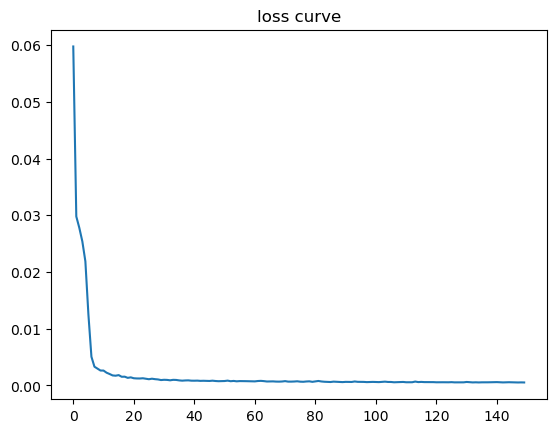

In [9]:
plt.plot(loss_plot)
plt.title("loss curve")

## 检测预测效果

In [10]:
model = TransformerModel(input_dim, output_dim,seq_len).to(device)
model.load_state_dict(torch.load('transformer_normalization_full.pt'))

model.eval()

BATCH_SIZE = 1
test_set = dataset_to_Dataset(test_input_merged,test_target2)
test_set_iter = DataLoader(dataset=test_set,batch_size=BATCH_SIZE,drop_last=True)

loss_data = []
y1_pred_data = []
y1_ref_data = []
for batch_idx, (x, y1) in enumerate(test_set_iter):
    x = x.reshape([BATCH_SIZE, input_size, 2])
    x = x.to(device)
    y1 = y1.reshape((BATCH_SIZE,power_size))
    y1 = y1.to(device)
    y1_pred = model(x)
    loss = criterion(y1, y1_pred)
    print(loss.item())
    loss_data.append(loss.item())
    y1_pred_data.append(y1_pred.detach().cpu().numpy())
    y1_ref_data.append(y1.detach().cpu().numpy())
    print(f"{batch_idx} has been finished")    

E:\Anaconda\AnacondaInstall\envs\pytorch\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


(500, 8760, 2)
(500, 8760)
torch.Size([500, 8760])
0.0030872467905282974
0 has been finished
0.005046900361776352
1 has been finished
0.0006624381057918072
2 has been finished
0.0035869297571480274
3 has been finished
0.005054469220340252
4 has been finished
0.0007118647336028516
5 has been finished
0.0021321449894458055
6 has been finished
0.002771097933873534
7 has been finished
0.003999719861894846
8 has been finished
0.003631098195910454
9 has been finished
0.0031078991014510393
10 has been finished
0.006473245564848185
11 has been finished
0.0010195657378062606
12 has been finished
0.006102702114731073
13 has been finished
0.002938848687335849
14 has been finished
0.0018613911233842373
15 has been finished
0.0046465410850942135
16 has been finished
0.0032126884907484055
17 has been finished
0.0009423402952961624
18 has been finished
0.004837320186197758
19 has been finished
0.0043683662079274654
20 has been finished
0.008056260645389557
21 has been finished
0.004110396374017
22 ha

[0.0030872467905282974, 0.005046900361776352, 0.0006624381057918072, 0.0035869297571480274, 0.005054469220340252, 0.0007118647336028516, 0.0021321449894458055, 0.002771097933873534, 0.003999719861894846, 0.003631098195910454, 0.0031078991014510393, 0.006473245564848185, 0.0010195657378062606, 0.006102702114731073, 0.002938848687335849, 0.0018613911233842373, 0.0046465410850942135, 0.0032126884907484055, 0.0009423402952961624, 0.004837320186197758, 0.0043683662079274654, 0.008056260645389557, 0.004110396374017, 0.005442922469228506, 0.008730726316571236, 0.006774027366191149, 0.0008038129890337586, 0.005364225246012211, 0.005009140353649855, 0.0014386862749233842, 0.0010665979934856296, 0.0013992686290293932, 0.001977130537852645, 0.007007482461631298, 0.002506435848772526, 0.0029550865292549133, 0.0033815433271229267, 0.002795030828565359, 0.0037350188940763474, 0.002643508603796363, 0.0009454165119677782, 0.0021918113343417645, 0.007388770580291748, 0.005498379934579134, 0.00779460836

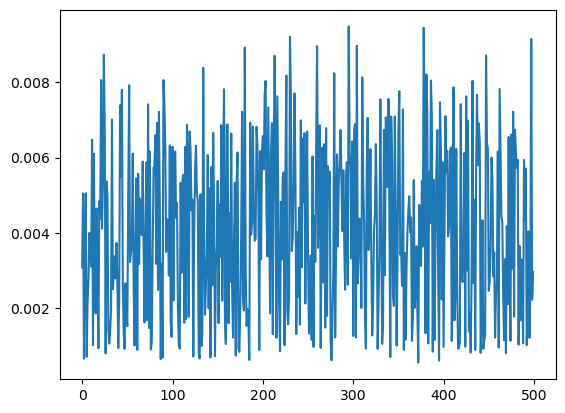

In [11]:
print(loss_data)
plt.plot(loss_data)

In [12]:
print(y1_pred_data[0].shape)
y1_pred_data = np.concatenate(y1_pred_data,axis=0)
print(y1_pred_data.shape)

(1, 8760)
(500, 8760)


In [13]:
print(y1_ref_data[0].shape)
y1_ref_data = np.concatenate(y1_ref_data,axis=0)
print(y1_ref_data.shape)

(1, 8760)
(500, 8760)


In [14]:
print(y1_ref_data[0])
print(y1_pred_data[0])

[0.16458668 0.12448894 0.09464707 ... 0.40592197 0.37362647 0.33127445]
[0.24903248 0.21519734 0.18672492 ... 0.44502687 0.42049772 0.35298032]


In [15]:
y1_relative_error = np.zeros_like(y1_ref_data)
for i in range(500):
    for j in range(8760):
        if y1_ref_data[i,j] <= 0.01:
            y1_relative_error[i,j] = np.abs((y1_ref_data[i,j] - y1_pred_data[i,j]))
        else:
            y1_relative_error[i,j] = np.abs((y1_ref_data[i,j] - y1_pred_data[i,j]) / y1_ref_data[i,j])

print(y1_relative_error.shape)
y1_relative_error[0]

y1_relative_error_mean = 0
for i in range(500):
    y1_relative_error_mean += np.mean(y1_relative_error[i,:])
y1_relative_error_mean /= 500
y1_relative_error_mean

(500, 8760)


0.15515754767507314

0.30546868


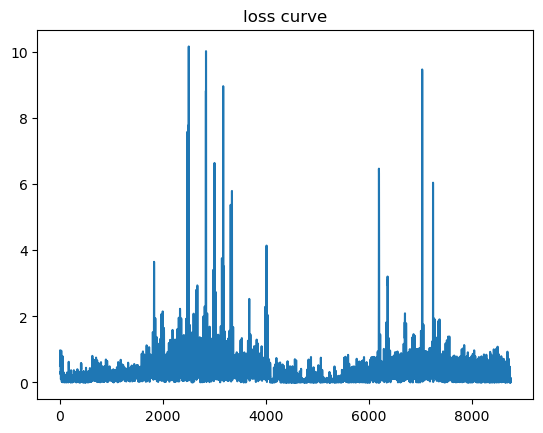

In [16]:
plt.plot(y1_relative_error[0])
plt.title("loss curve")
print(np.mean(y1_relative_error[0]))

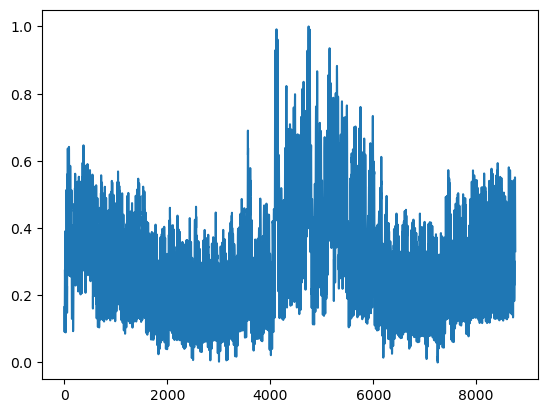

In [18]:
plt.plot(y1_ref_data[0])
# plt.plot(y1_pred_data[0])

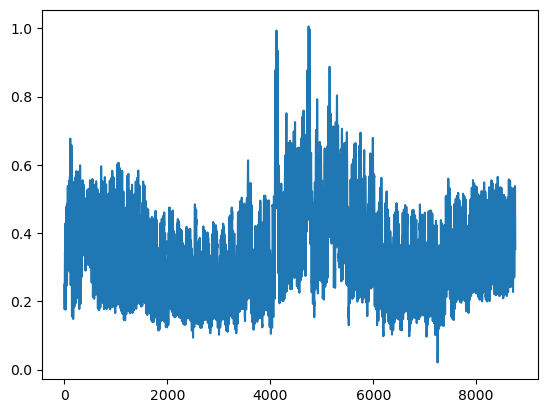

In [19]:
plt.plot(y1_pred_data[0])

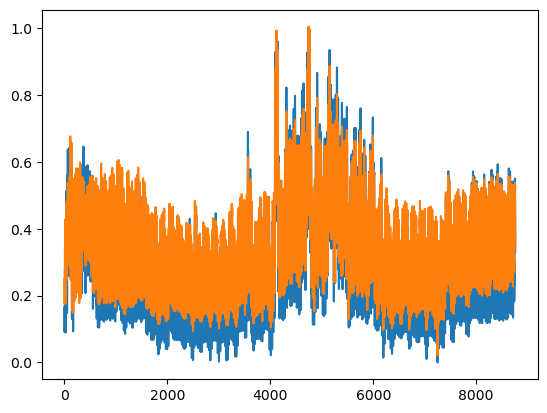

In [20]:
plt.plot(y1_ref_data[0])
plt.plot(y1_pred_data[0])